# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain==0.3.0 langchain_community==0.3.0 langchain_openai==0.2.0 langchain_qdrant==0.1.4 langsmith==0.1.121
!pip install pymupdf==1.24.10 qdrant-client==1.11.2 

We'll need an OpenAI API Key:

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - 9acc7473


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [5]:
import sys

if "google.colab" in sys.modules:
    from google.colab import files
    uploaded = files.upload()

In [6]:
if "google.colab" in sys.modules:
    file_path = list(uploaded.keys())[0]
    file_path

In [7]:
# Since I'm not using Colab, let's use tkinter to upload 

if "google.colab" not in sys.modules:
    # For local file selection, using Tkinter for a dialog
    from tkinter import Tk
    from tkinter.filedialog import askopenfilename

    def upload_file() -> str:
        
        # Create a root window and hide it
        root = Tk()
        root.withdraw()

        # Ask for file selection
        file_path = askopenfilename(title="Select a file")

        # Open and read the selected file
        with open(file_path, 'rb') as file:
            content = file.read()

        print("Path for uploaded file:", file_path)

        return file_path

    file_path = upload_file()

2024-10-06 12:49:07.881 python[54118:1333457] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-06 12:49:08.127 python[54118:1333457] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


Path for uploaded file: /Users/david/Desktop/aie4/Week 8/Day 1/docs/1706.03762v7.pdf


We'll define our chunking strategy.

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [9]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [10]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings
# DES
import time

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)

# DES
start_time = time.time()
vectorstore.add_documents(docs)
end_time = time.time()
print(f"First run took: {end_time - start_time} seconds")

retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

First run took: 0.7675721645355225 seconds


##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

ANSWER

First, let's identify what is being cached:
- Text embeddings generated by the OpenAIEmbeddings model are cached in the local file store at ./cache/.
- The cache is checked whenever embeddings are required, and if they are already computed and stored, they are reused instead of re-computed.

This caching mechanism should help improve performance, especially when dealing with large documents or repeated queries.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [11]:
import time

# Time the second embedding operation using the same docs (should be faster due to caching)
start_time = time.time()
vectorstore.add_documents(docs)
end_time = time.time()
print(f"Second run (with cache) took: {end_time - start_time} seconds")



Second run (with cache) took: 0.030025005340576172 seconds


EXPERIMENT RESULTS

- First run was 0.7675721645355225 seconds
- Second run was 0.030025005340576172 seconds

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [13]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [19]:
from langchain_core.caches import InMemoryCache

# DES - Create a cache object
cache = InMemoryCache()

set_llm_cache(cache)

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

There are two major disdvantages of an in memory cache like this:  
- It's not persistent so if the container / host restarts the cache will be lost
- The cache is not application wide
- Managing stale data if the underlying corpus changes

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [21]:
import time

# Clear the cache before running the test
cache.clear()

# Time the first predict operation 
start_time = time.time()
result = chat_model.predict("Who are the authors of the paper?")
print(result)
end_time = time.time()
print(f"Firt run took: {end_time - start_time} seconds")

# Time the first predict operation using the same question (should be faster due to caching)
start_time = time.time()
result = chat_model.predict("Who are the authors of the paper?")
print(result)
end_time = time.time()
print(f"Second run (with cache) took: {end_time - start_time} seconds")

I would need more information about the specific paper you're referring to in order to identify the authors. Could you provide the title or subject of the paper?
Firt run took: 1.482785940170288 seconds
I would need more information about the specific paper you're referring to in order to identify the authors. Could you provide the title or subject of the paper?
Second run (with cache) took: 0.0009510517120361328 seconds


EXPERIMENT RESULTS

- Firt run took 1.482785940170288 seconds
- Second run (with cache) took 0.0009510517120361328 seconds!

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [22]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [23]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 10 things about this document in a bullet format!"})

AIMessage(content="- The document is a PDF file with a total of 15 pages.\n- It was created using LaTeX with hyperref and produced by pdfTeX-1.40.25.\n- The creation and modification date of the document are both recorded as April 10, 2024.\n- The content includes discussions about the law and its application, emphasizing the need for justice despite the imperfection of the law.\n- There are references to attention heads in a layer of a neural network, specifically related to anaphora resolution.\n- A table within the document presents variations on the Transformer architecture, highlighting different model configurations and their corresponding metrics.\n- The metrics include values such as perplexity (PPL), BLEU scores, and the number of parameters for various models.\n- The document cites multiple references, including works by Zhouhan Lin and Minh-Thang Luong, associated with advancements in machine learning and neural networks.\n- Specific attention is given to how the model's per

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

These screenshots from LangSmith show the the big difference I noted between the two runs.

Screenshot of first run showing the ChatOpenAI call took 2.18 seconds

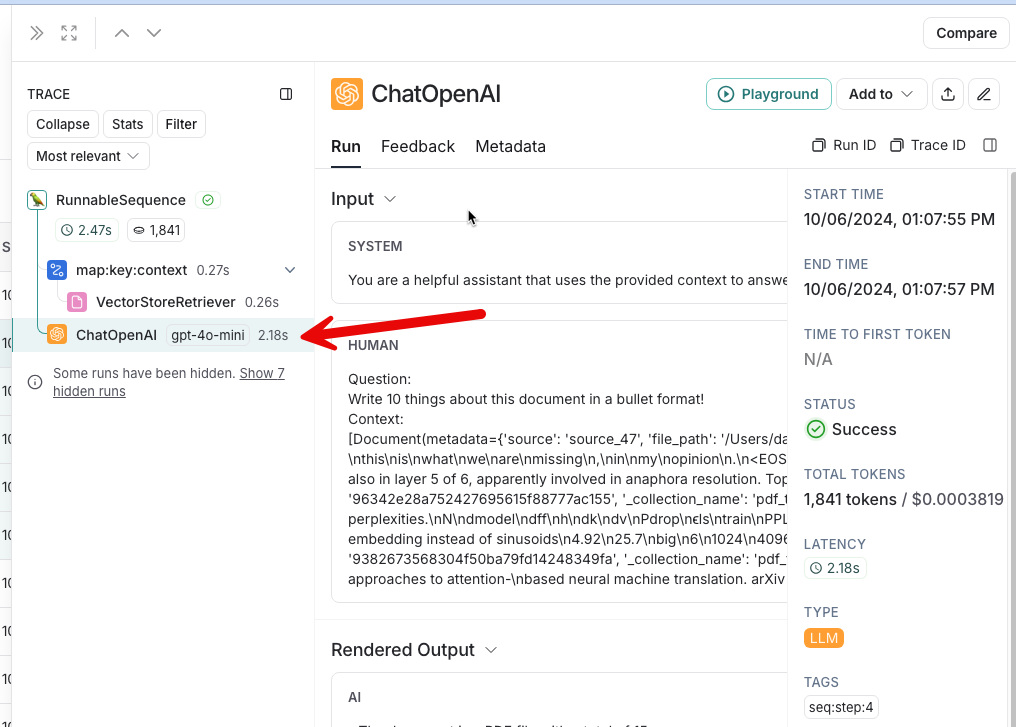

Screenshot of second run showing the ChatOpenAI call took 0.00 seconds! 

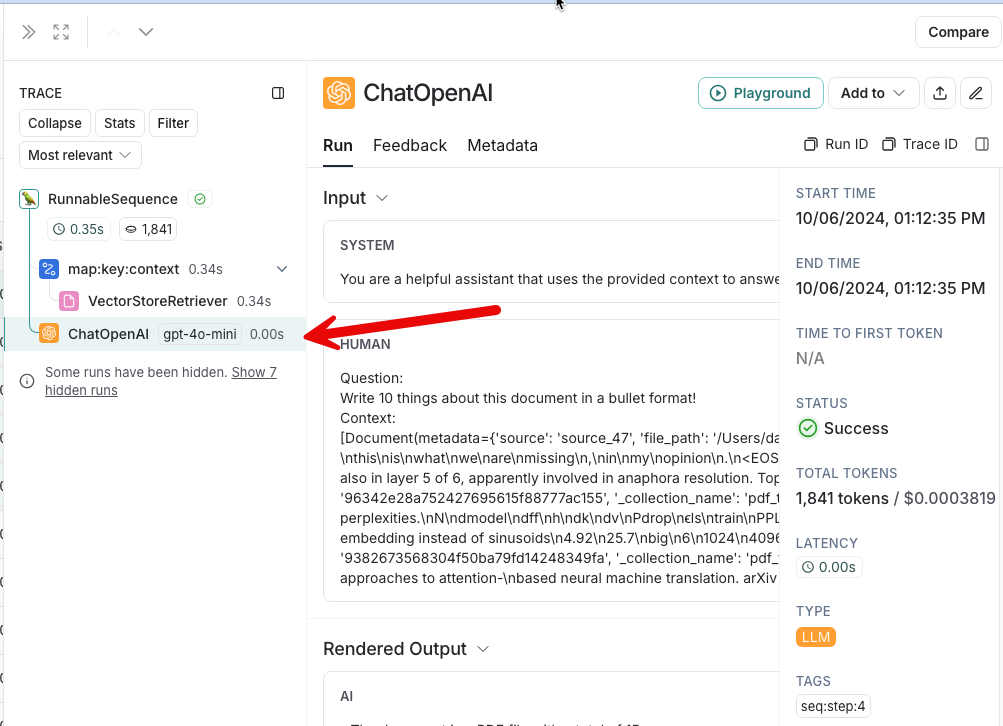

In [24]:
# Let's run the query again and check the LangSmith trace
retrieval_augmented_qa_chain.invoke({"question" : "Write 10 things about this document in a bullet format!"})

AIMessage(content="- The document is a PDF file with a total of 15 pages.\n- It was created using LaTeX with hyperref and produced by pdfTeX-1.40.25.\n- The creation and modification date of the document are both recorded as April 10, 2024.\n- The content includes discussions about the law and its application, emphasizing the need for justice despite the imperfection of the law.\n- There are references to attention heads in a layer of a neural network, specifically related to anaphora resolution.\n- A table within the document presents variations on the Transformer architecture, highlighting different model configurations and their corresponding metrics.\n- The metrics include values such as perplexity (PPL), BLEU scores, and the number of parameters for various models.\n- The document cites multiple references, including works by Zhouhan Lin and Minh-Thang Luong, associated with advancements in machine learning and neural networks.\n- Specific attention is given to how the model's per